In [1]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False 

In [ ]:
import duckdb
import altair as alt
from IPython.display import Image, display

alt.renderers.enable('default')
alt.data_transformers.enable('default')

%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

Tip: You may define configurations in /users/j/s/jstonge1/wikigrams/pyproject.toml or /users/j/s/jstonge1/.jupysql/config.

Did not find user configurations in /users/j/s/jstonge1/wikigrams/pyproject.toml.

## Loading data from Michael's account
- keep only types and counts
- hive partition

In [ ]:
# %%sql
# COPY (
#     SELECT
#         column1 as types,
#         CAST(count AS BIGINT) as counts,
#         ROW_NUMBER() OVER (PARTITION BY regexp_extract(filename, '(\d{4}-\d{2}-\d{2})_', 1)
#                           ORDER BY CAST(count AS BIGINT) DESC) as rank,
#         CAST(regexp_extract(filename, '(\d{4}-\d{2}-\d{2})_', 1) AS DATE) as date
#     FROM read_csv('/gpfs1/home/m/v/mvarnold/wikipedia-parsing/data/1grams/*_wikipedia_1grams.tsv',
#                   delim='\t',
#                   header=true,
#                   filename=true)
#     WHERE column0 = 'United States'
# ) TO '/netfiles/compethicslab/wikimedia_temp/1grams_parquet' (
#     FORMAT PARQUET,
#     PARTITION_BY (date),
#     COMPRESSION 'ZSTD',
#     ROW_GROUP_SIZE 100000
# );

In [16]:
!du -sh /netfiles/compethicslab/wikimedia_temp/1grams_parquet

20G	/netfiles/compethicslab/wikimedia_temp/1grams_parquet


In [17]:
%sql SELECT * FROM read_parquet('/netfiles/compethicslab/wikimedia_temp/1grams_parquet/**/*.parquet', hive_partitioning=true) LIMIT 100;

,types,counts,rank,date
0,",",24328673450,1,2024-09-30
1,the,18730097558,2,2024-09-30
2,.,16954394529,3,2024-09-30
3,of,10112671456,4,2024-09-30
4,and,9661875240,5,2024-09-30
...,...,...,...,...
95,out,279582684,96,2024-09-30
96,only,278722453,97,2024-09-30
97,4,277366669,98,2024-09-30
98,million,277255716,99,2024-09-30


In [18]:
%%sql
daily_types_df = << SELECT                                                                      
    date,                                                                   
    COUNT(*) as uniq_types,
    SUM(counts) as total_token,                                                 
FROM read_parquet('/netfiles/compethicslab/wikimedia_temp/1grams_parquet/**/*.parquet', hive_partitioning=true)  
GROUP BY date                                                               
ORDER BY date;                                                              
                                                                            

,date,uniq_types,total_token
0,2024-09-30,6239008,4.281767e+11
1,2024-10-01,6019198,4.097350e+11
2,2024-10-02,5808876,3.841973e+11
3,2024-10-03,5330266,3.069824e+11
4,2024-10-04,5482154,3.338160e+11
...,...,...,...
410,2025-11-29,6075936,4.860295e+11
411,2025-11-30,6325652,5.609655e+11
412,2025-12-01,6381935,4.205002e+11
413,2025-12-02,6226386,4.414897e+11


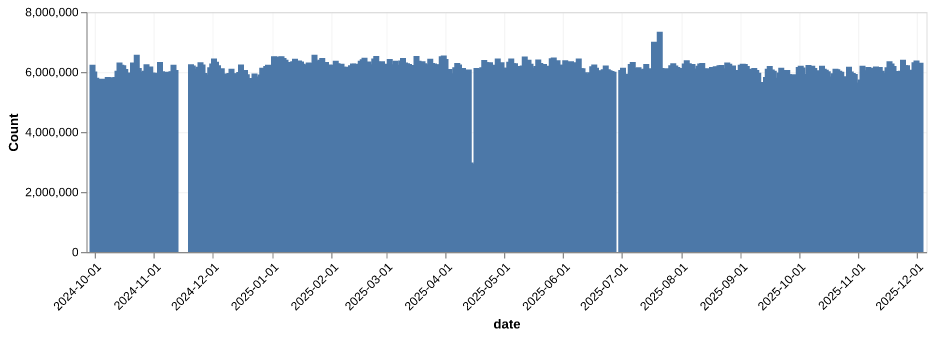

In [19]:
alt.Chart(daily_types_df).mark_bar().encode(
    x=alt.X('date:T', 
            axis=alt.Axis(labelAngle=-45, 
                         format='%Y-%m-%d')),  # Format as YYYY-MM-DD
    y=alt.Y('uniq_types:Q', title='Count'),
    tooltip=['date:T', 'uniq_types:Q']
).properties(
    width=700,
    height=200
).configure_axis(
    grid=True,
    gridOpacity=0.3
).save('chart.png', scale_factor=1.2)

Image('chart.png')

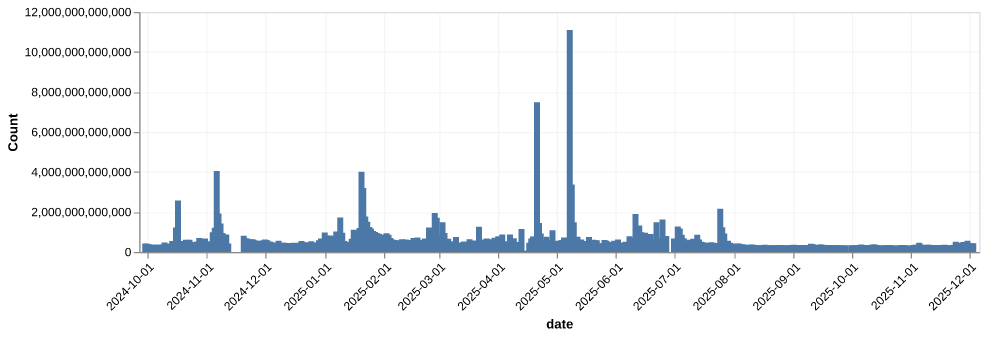

In [20]:
alt.Chart(daily_types_df).mark_bar().encode(
    x=alt.X('date:T', 
            axis=alt.Axis(labelAngle=-45, 
                         format='%Y-%m-%d')),  # Format as YYYY-MM-DD
    y=alt.Y('total_token:Q', title='Count'),
    tooltip=['date:T', 'total_token:Q']
).properties(
    width=700,
    height=200
).configure_axis(
    grid=True,
    gridOpacity=0.3
).save('chart.png', scale_factor=1.2)

Image('chart.png')

3.2s to do an AGGREGATED SUM on what used to be a large amount of data because of our hive partition. We only read what we need to read in this query.